In [1]:
# Setup autoreload and add parent dir to sys.path
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')

In [2]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import tensorflow_privacy
from typing import Tuple
from utils import make_deterministic

make_deterministic()
plt.rcParams['font.size'] = 22

dtype = np.float64
gpflow.config.set_default_float(dtype)

gpus = tf.config.list_physical_devices('GPU')
print("\n GPU", gpus)
try:
  tf.config.experimental.set_memory_growth(gpus[0], True)
except:
  print("Couldn't set flexible memory growth, found GPU", gpus)


 GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
save_figs=False
N = 50  # Number of training observations
def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 2) + 0.5 * np.sin(15*x)

X = np.random.rand(N, 1) * 1.3 - 1  # X values
Y = func(X) + 0.3 * np.random.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)

0

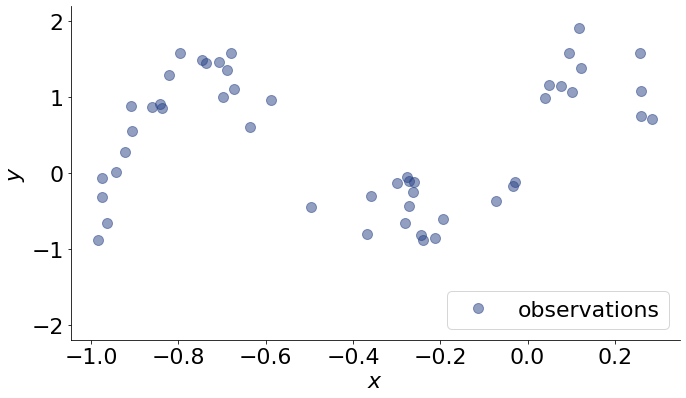

In [9]:
plt.figure(figsize=(10, 6))
ylim=(-2.2, 2.2)
plt.plot(X, Y, ".", label="observations", alpha=0.5, markersize='20',color='#264185')
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
sns.despine()
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.savefig("../figures/local_dp/underlying_func.pdf") if save_figs else 0

In [10]:
n_inducing = 10
Z = np.random.uniform(-0.3, 0.3, size=(n_inducing, 1))
k = gpflow.kernels.SquaredExponential()
m = gpflow.models.SGPR((X, Y), kernel=gpflow.kernels.SquaredExponential(), inducing_variable=Z)
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(10, 1)",float64,[[-0.29068003...


In [11]:
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=2_000))

      fun: 24.036994057495733
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.09102699e-04,  4.66332837e-04, -2.73402352e-04, -1.13623852e-04,
        4.74292843e-04, -3.59171682e-06,  2.03046348e-04,  3.35794786e-04,
       -4.45727363e-04,  4.20297118e-04, -3.38114403e-04,  5.08287176e-05,
        3.64666801e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 53
     njev: 80
   status: 0
  success: True
        x: array([-0.97165705, -0.28930552, -0.62608271,  0.10041623, -0.73079321,
        0.26671605, -0.44162741, -0.87286261, -0.20919214, -0.0232373 ,
       -1.77120351,  0.59732925, -2.49939688])

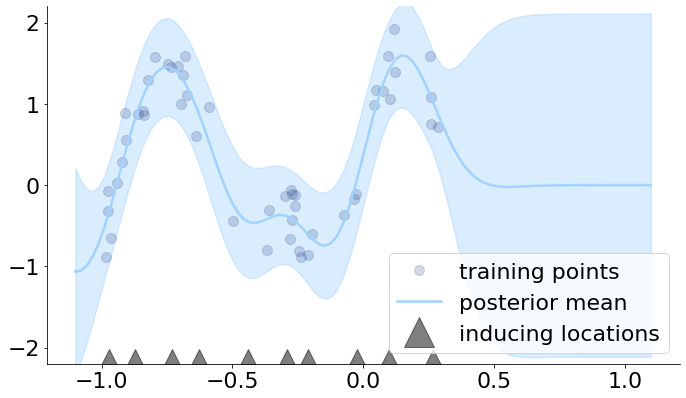

In [13]:
from utils import plot_model
plot_model(m, (X, Y), predict_y=True, ms='20')
plt.savefig("../figures/sgpr_inducing.pdf")